In [1]:
import json
import pandas as pd
import os
from typing import List
from datetime import datetime
import re

In [2]:
ML_JOB_PATH = "machine-learning-jobs20221109161820.jsonl"
DS_JOB_PATH = "sample20221109145023.jsonl"

RANDOM_STATE = 42

In [3]:
def validate_data_path(data_path:str):
    """Validates data path

    Args:
        data_path (str): path of the data

    Raises:
        FileNotFoundError: File does not exist
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(data_path)

In [4]:
# not all data point is perfect, for those with errors I will ignore

def return_data(data_path:str)->List:
    """Returns job detail from on job posting

    Args:
        data_path (str): Path of the data

    Returns:
        List: A list full of the job posting, each a dictionary
    """
    validate_data_path(data_path)
    data_list = []
    with open(data_path, 'r') as reader:
        for line in reader.readlines():
            data = json.loads(line)
            # Errors are only contained in the dictionary
            if isinstance(data,dict):
                continue
            data_list.append(data)
    return data_list

In [5]:
ML_JOB_RAW_DATA = return_data(ML_JOB_PATH)
DS_JOB_RAW_DATA = return_data(DS_JOB_PATH)

In [6]:
len(ML_JOB_RAW_DATA)

224

In [7]:
len(DS_JOB_RAW_DATA)

1212

In [8]:
TOTAL_JOB_RAW_DATA = ML_JOB_RAW_DATA + DS_JOB_RAW_DATA

In [9]:
len(TOTAL_JOB_RAW_DATA)

1436

In [10]:
# Attempting to fetch headers from their respective cols
headers = {}
for row in TOTAL_JOB_RAW_DATA:
    for col in range(1,len(row)):
        for key in row[col].keys():
            if str(key) + '_' + str(col) in headers:
                headers[f"{key}_{col}"] +=1
            else: 
                headers[f"{key}_{col}"] = 1

In [11]:
len(headers)

1299

In [12]:
# This is a slice of all of the headers found coz otherwise it will be too big
headers_slice = {k:headers[k] for k in list(headers)[:15]}

In [13]:
headers_slice

{'company_name_1': 1436,
 'small_section_2': 1436,
 'Responsibilities:\xa0_3': 6,
 '\xa0_3': 10,
 'Essential Skills:_3': 2,
 'Career Level_4': 1436,
 'Qualification_4': 1434,
 'Years of Experience_4': 1241,
 'Job Type_4': 1436,
 'Job Specializations_4': 1436,
 'Registration No._4': 1429,
 'Company Size_4': 1411,
 'Industry_4': 1434,
 'Benefits & Others_4': 1151,
 'Company Overview_5': 1419}

In [14]:
# These headers have values for all jobs

full_header = [k for k,v in headers.items() if v == len(TOTAL_JOB_RAW_DATA)]
full_header

['company_name_1',
 'small_section_2',
 'Career Level_4',
 'Job Type_4',
 'Job Specializations_4',
 'url_6']

I am expecting all information to be filled in:
- First col: Job position
- Second col: Details of the job including pay, location (General and or specific), 
- Fourth col: Misc details of the company including size of company, dress code etc
- Fifth col: Company Overview, details on the company
- Sixth col: URL

Within the second col I expect there are also some headers to be further broken down. 

The largest one will have to be the second col with the job description being the most variable component of the posting. I suspect most of the work will be done in here to uncover as much information as possible.

The desired outcome will be a consolidated pandas dataframe with as little information loss as possible.

# Preprocess

## Full Columns

In [15]:
# We do see some artifacts in the job titles like
# - Job reference number
# - Hashtags

job_reference_pattern = r"\(?\w+\d+\)?"
hashtag_pattern = r"#\w+"

data = {}
job_title,company_name,career_level,job_type, job_specialisations, url = [],[],[],[],[],[]
for row in TOTAL_JOB_RAW_DATA:
    position = row[0]['position']
    position = re.sub(job_reference_pattern, "",position)
    position = re.sub(hashtag_pattern, "",position)
    position = position.replace("*","").replace("-","")
    company_name.append(row[1]['company_name'])
    job_title.append(position)
    career_level.append(row[4]['Career Level'])
    job_type.append(row[4]['Job Type'])
    job_specialisations.append(row[4]['Job Specializations'])
    url.append(row[6]['url'])

data['job_title'] = job_title
data['company_name'] = company_name
data['career_level'] = career_level
data['job_type'] = job_type
data['job_specialisations'] = job_specialisations
data['url'] = url

assert (len(job_title) == len(career_level)==len(job_type)==len(job_specialisations)==len(url))

In [16]:
# Already we can see some field contains some other information like the job_title containing job type, location and company name for instance
pd.DataFrame.from_dict(data).tail()

job_title  \
1431                Research Associate (Bioprinting),     
1432                     Data Science Analyst, TikTok     
1433    Data Analyst  Senior (1 year contract, Central)   
1434                   Junior Machine Learning Engineer   
1435  Senior Process Development Scientist (Organic ...   

                                           company_name      career_level  \
1431                   Nanyang Technological University  Junior Executive   
1432                                             TikTok       Entry Level   
1433  PERSOLKELLY Singapore Pte Ltd (Formerly Kelly ...  Senior Executive   
1434                                  Dell Asia Pte Ltd  Junior Executive   
1435  PERSOLKELLY Singapore Pte Ltd (Formerly Kelly ...  Senior Executive   

       job_type                           job_specialisations  \
1431  Full-Time                Sciences, Science & Technology   
1432  Full-Time  Computer/Information Technology, IT-Software   
1433  Temporary       Manufacturing, Purchasing/Material Mgmt   
1434  Full-Time  Computer/Information Technology, IT-Software   
1435  Full-Time                           Sciences, Chemistry   

                                                    url  
1431  http://www.jobstreet.com.sg/en/job/research-as...  
1432  http://www.jobstreet.com.sg/en/job/data-scienc...  
1433  http://www.jobstreet.com.sg/en/job/data-analys...  
1434  http://www.jobstreet.com.sg/en/job/junior-mach...  
1435  http://www.jobstreet.com.sg/en/job/senior-proc...

In [17]:
# Already we can see some field contains some other information like the job_title containing job type, location and company name for instance
pd.DataFrame.from_dict(data).sample(15, random_state=RANDOM_STATE)

job_title  \
594   Executive, Healthcare Information (Analytics A...   
754   Research Associate, (Computer Science/Electric...   
630         Research Engineer I,  (Computer Science)      
1259                Research Scientist  (Engineering)     
903   Research Assistant,  (Microbiology  Wastewater...   
1175                            Lead Data Scientist,      
762   SVP / VP, Delivery Lead (Digital Banking), Gro...   
1372             Research Scientist (Microfabrication)    
259   Research Assistant (Computer Science and Data ...   
316      Solution Lead, Sensors & Machine Learning Lab    
705                     Chief Scientific Officer (EDDC)   
906                     Data Scientist Intern,  Growth    
274   Assistant Manager/Assistant Principal Data Ana...   
361   Research Fellow (Signal Processing and Machine...   
743   Associate/ Data Engineer, Government Infrastru...   

                                           company_name      career_level  \
594                              SingHealth Polyclinics  Junior Executive   
754                    Nanyang Technological University  Junior Executive   
630                    Nanyang Technological University  Junior Executive   
1259                   Nanyang Technological University  Junior Executive   
903                    Nanyang Technological University  Junior Executive   
1175      ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD           Manager   
762                                    DBS Bank Limited    Senior Manager   
1372                   Nanyang Technological University  Junior Executive   
259                    Nanyang Technological University       Entry Level   
316          Changi Airport Group (Singapore) Pte. Ltd.    Senior Manager   
705   Agency for Science, Technology and Research (A...  Junior Executive   
906                                              TikTok       Entry Level   
274                                  ST Engineering Ltd           Manager   
361                    Nanyang Technological University  Junior Executive   
743   Government Technology Agency of Singapore (Gov...  Junior Executive   

        job_type                                job_specialisations  \
594    Full-Time  Admin/Human Resources, Clerical/Administrative...   
754    Full-Time       Computer/Information Technology, IT-Software   
630    Full-Time       Computer/Information Technology, IT-Software   
1259   Full-Time       Computer/Information Technology, IT-Software   
903    Full-Time                     Sciences, Science & Technology   
1175   Full-Time       Computer/Information Technology, IT-Software   
762    Full-Time       Computer/Information Technology, IT-Software   
1372   Full-Time                     Sciences, Science & Technology   
259    Full-Time       Computer/Information Technology, IT-Software   
316    Full-Time       Computer/Information Technology, IT-Software   
705    Full-Time                     Sciences, Science & Technology   
906   Internship       Computer/Information Technology, IT-Software   
274    Full-Time  Computer/Information Technology, IT-Network/Sy...   
361    Full-Time                            Engineering, Electrical   
743    Full-Time  Computer/Information Technology, IT-Network/Sy...   

                                                    url  
594   http://www.jobstreet.com.sg/en/job/executive-h...  
754   http://www.jobstreet.com.sg/en/job/research-as...  
630   http://www.jobstreet.com.sg/en/job/research-en...  
1259  http://www.jobstreet.com.sg/en/job/research-sc...  
903   http://www.jobstreet.com.sg/en/job/research-as...  
1175  http://www.jobstreet.com.sg/en/job/lead-data-s...  
762   http://www.jobstreet.com.sg/en/job/svp-vp-deli...  
1372  http://www.jobstreet.com.sg/en/job/research-sc...  
259   http://www.jobstreet.com.sg/en/job/research-as...  
316   http://www.jobstreet.com.sg/en/job/solution-le...  
705   http://www.jobstreet.com.sg/en/job/chief-scien...  
906   http://www.jobstreet.com.sg/e

## Partial Columns

### Small Section

This is where the trouble/fun starts. Lets start with the small section


In [18]:
# The small section contains a list with location, salary (if available) and then post date
for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    if idx > 20 :
        break
    else:
        print(row[2])

{'small_section': ['Central', 'SGD\xa06,000 - SGD\xa012,000', 'Posted on 4-Nov-22']}
{'small_section': ['Singapore', 'Posted 1 hour ago']}
{'small_section': ['Singapore', 'Posted on 8-Nov-22']}
{'small_section': ['Central - Others', 'Posted on 6-Nov-22']}
{'small_section': ['Singapore', 'Posted on 8-Nov-22']}
{'small_section': ['Singapore', 'Posted on 7-Nov-22']}
{'small_section': ['Novena', 'Posted on 7-Nov-22']}
{'small_section': ['Singapore', 'Posted on 7-Nov-22']}
{'small_section': ['Singapore', 'Posted on 5-Nov-22']}
{'small_section': ['Singapore', 'Posted on 7-Nov-22']}
{'small_section': ['Singapore', 'Posted on 5-Nov-22']}
{'small_section': ['Central - Others', 'SGD\xa04,000 - SGD\xa06,000', 'Posted on 3-Nov-22']}
{'small_section': ['Singapore', 'Posted on 7-Nov-22']}
{'small_section': ['West', 'Posted 11 hours ago']}
{'small_section': ['Singapore', 'Posted on 4-Nov-22']}
{'small_section': ['Singapore', 'Posted on 6-Nov-22']}
{'small_section': ['Singapore', 'Posted 11 hours ago'

In [19]:
demo = 'Posted on 7-Nov-22'

In [20]:
demo.split("Posted on")[1].strip()

'7-Nov-22'

In [21]:
datetime.strptime(demo.split("Posted on")[1].strip(),'%d-%b-%y')

datetime.datetime(2022, 11, 7, 0, 0)

In [22]:
curr_date = ML_JOB_PATH[21:-12]

In [23]:
curr_date

'20221109'

In [24]:
datetime.strptime(curr_date, '%Y%m%d').year

2022

In [25]:
def extract_date_from_posted_date(sample_text:str, file_path:str)->datetime:
    """Return posted date in datetime format

    Args:
        sample_text (str): sample text from the row
        file_path (str): File path from the data in jsonl format
        to determine the current date

    Returns:
        datetime: When the job was posted
    """
    if 'on' in sample_text:
        sample_date = sample_text.split("Posted on")[1].strip()
        return datetime.strptime(sample_date,'%d-%b-%y')
    else:
        curr_date = file_path[21:-12]
        return datetime.strptime(curr_date, '%Y%m%d')

In [26]:
# For location, we will take in anything that is other than Singapore, if Singapore we will leave it as unspecified
# For Salary, we will clean up the html artifact '\xa0' and seperate into low to high
# For Post date, we will just take in as is. Any variant of Posted on xxx will be tagged as the date of extraction which is collected on the jsonl file

location, low_salary, high_salary, post_date = [],[],[],[]

curr_date = ML_JOB_PATH[21:-12]

for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    select_row = row[2]['small_section']
    # location
    try:
        # There are instances where no location is entered 
        if select_row[0] is not None: 
            if 'sin' not in select_row[0].lower():
                location.append(select_row[0])
            else:
                location.append('unspecified')    
        else:
            location.append('unspecified')
        # check for salary, otherwise its posted date
        if 'sgd' in select_row[1].lower():
            if "\xa0" in select_row[1].lower():
                low_salary.append(select_row[1].split("\xa0")[1].split('-')[0].strip())
                high_salary.append(select_row[1].split("\xa0")[2].strip())
            else:
                salary = select_row[1].lower().split('sgd')[1].strip()
                low_salary.append(salary)
                high_salary.append(salary)
        # if sgd not in this value, it must be posted date
        else:
            salary = 'unspecified'
            low_salary.append(salary)
            high_salary.append(salary)
            post_date.append(extract_date_from_posted_date(select_row[1], ML_JOB_PATH))
        # if third value is present, it must be posted date
        if len(select_row) == 3:
            post_date.append(extract_date_from_posted_date(select_row[1], ML_JOB_PATH))
    except Exception as e:
        print(f"{idx} with {row} has issue {e}")

assert (len(location)==len(low_salary)==len(high_salary)==len(post_date))

In [27]:
data['location'] = location
data['low_salary'] = low_salary
data['high_salary'] = high_salary
data['post_date'] = post_date

In [28]:
pd.set_option('max_colwidth', 400)

In [29]:
# This is how the dataframe looks like so far.
pd.DataFrame.from_dict(data).sample(15,random_state=RANDOM_STATE)

job_title  \
594                                                                   Executive, Healthcare Information (Analytics And Training)   
754                                                               Research Associate, (Computer Science/Electrical Engineering)    
630                                                                                  Research Engineer I,  (Computer Science)      
1259                                                                                         Research Scientist  (Engineering)     
903                                                                Research Assistant,  (Microbiology  Wastewater Surveillance)    
1175                                                                                                     Lead Data Scientist,      
762   SVP / VP, Delivery Lead (Digital Banking), Group Consumer Banking and Big Data Analytics Technology, Technology & Operat     
1372                                                                                      Research Scientist (Microfabrication)    
259                                                                      Research Assistant (Computer Science and Data Science)    
316                                                                               Solution Lead, Sensors & Machine Learning Lab    
705                                                                                              Chief Scientific Officer (EDDC)   
906                                                                                              Data Scientist Intern,  Growth    
274                                                                           Assistant Manager/Assistant Principal Data Analyst   
361                                                                 Research Fellow (Signal Processing and Machine Learning),  T   
743                                                                   Associate/ Data Engineer, Government Infrastructure Group    

                                              company_name      career_level  \
594                                 SingHealth Polyclinics  Junior Executive   
754                       Nanyang Technological University  Junior Executive   
630                       Nanyang Technological University  Junior Executive   
1259                      Nanyang Technological University  Junior Executive   
903                       Nanyang Technological University  Junior Executive   
1175         ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD           Manager   
762                                       DBS Bank Limited    Senior Manager   
1372                      Nanyang Technological University  Junior Executive   
259                       Nanyang Technological University       Entry Level   
316             Changi Airport Group (Singapore) Pte. Ltd.    Senior Manager   
705   Agency for Science, Technology and Research (A*STAR)  Junior Executive   
906                                                 TikTok       Entry Level   
274                                     ST Engineering Ltd           Manager   
361                       Nanyang Technological University  Junior Executive   
743    Government Technology Agency of Singapore (GovTech)  Junior Executive   

        job_type                                       job_specialisations  \
594    Full-Time    Admin/Human Resources, Clerical/Administrative Support   
754    Full-Time              Computer/Information Technology, IT-Software   
630    Full-Time              Computer/Information Technology, IT-Software   
1259   Full-Time              Computer/Information Technology, IT-Software   
903    Full-Time                            Sciences, Science & Technology   
1175   Full-Time              Computer/Information Technology, IT-Software   
762    Full-Time              Computer/Information Technology, IT-Software   
1372   Full-Time                            Sciences, Science & Technology   
259    Full-Time       

Some cleanup is still needed in the Job title as posters tend to put in some additional remarks there

### Job description

Because this section is pretty much is an open format for text to be dumped, the rationale for the scrapping rules is that it would be easier to identify actual JDs as they tend to be encapsulated in list format preceded by a header in bold. Of course the actual JD could be contained in some other format however this is one way to remove extra information like standard clauses by companies.  

In [30]:
# Remove the _3 suffix attached to the key
jd_headers = {key[:-2]:headers[key] for key in list(headers) if key.endswith('3')}

In [31]:
len(jd_headers)

1283

In [32]:
sorted_jd_headers = dict(sorted(jd_headers.items(), key=lambda item: item[1], reverse=True))

In [33]:
# in this instance we see most of them are captured under expected headers like Job requirements, responsibilites, requirements and similar variants
# 20 shown only for visibility
{key:sorted_jd_headers[key] for key in list(sorted_jd_headers)[:20]}

{'Job Requirements:': 266,
 'Responsibilities': 240,
 'Job Requirements': 239,
 'Qualifications': 212,
 'Job Responsibilities': 186,
 'Key Responsibilities:': 171,
 'Responsibilities:': 103,
 'Requirements:': 99,
 'Requirements': 97,
 'Job Description': 79,
 'Job Description:': 71,
 'The above eligibility criteria are not exhaustive. A*STAR may include additional selection criteria based on its prevailing recruitment policies. These policies may be amended from time to time without notice. We regret that only shortlisted candidates will be notified.': 53,
 'Key Responsibilities:\xa0': 47,
 'Job Requirements:\xa0': 44,
 'Job Responsibilities:': 42,
 'Preferred Qualifications': 30,
 'Qualifications:': 30,
 'Key Responsibilities': 29,
 'Minimum Qualifications': 25,
 'Overview': 25}

I imagine JDs would then have two sections:
- the Actual Job description
- Their requirements in a candidate

My next approach is to gather all of the headers that correspond to those two categories and fill them up with values.
The difficulty here is that there is no consistent format for the companies or posters to list them unlike the previous categories. Taking the whole information and dumping them in one category or sieving them is also a big problem, thus my approach of taking bullet points from headers.

In [34]:
# Some quick EDA
# so we see that not all headers contain valid values even if the keys are valid like the first example there
TOTAL_JOB_RAW_DATA[0][3]

{'Responsibilities:\xa0': '',
 '\xa0': 'Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and platform engineering..',
 'Essential Skills:': 'At least five years’ experience in a predictive analytics or Artificial Intelligence / Machine-learning role, or in modelling comple

In [35]:
TOTAL_JOB_RAW_DATA[2][3].keys()

dict_keys(['NLP\xa0and\xa0Knowledge Graph Engineer, Sensors & Machine Learning Lab', 'Responsibilities:', 'Preferred Requirements:'])

In [36]:
# My first step is just to remove the key value pairs where there is no values or have values of a certain length..
for posting in TOTAL_JOB_RAW_DATA:
    print(posting)
    for jd in posting[3]:
        print(jd)
        break


[{'position': 'Associate Director, Risk Analytics'}, {'company_name': 'Olea Global Pte. Ltd.'}, {'small_section': ['Central', 'SGD\xa06,000 - SGD\xa012,000', 'Posted on 4-Nov-22']}, {'Responsibilities:\xa0': '', '\xa0': 'Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and

In [37]:
temp_dict = TOTAL_JOB_RAW_DATA[500][3]

In [38]:
TOTAL_JOB_RAW_DATA[0][3]

{'Responsibilities:\xa0': '',
 '\xa0': 'Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and platform engineering..',
 'Essential Skills:': 'At least five years’ experience in a predictive analytics or Artificial Intelligence / Machine-learning role, or in modelling comple

In [39]:
for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    JD = row[3]
    try:
        row[3] = {k.replace("\xa0"," ").replace(":",""):v.replace("\xa0"," ") for k, v in JD.items() if len(v) >10 }
    except Exception as e:
        print(f"Unable to process at idx {idx} due to {e}")

In [40]:
# Confirmed that any header with no value gets taken out
TOTAL_JOB_RAW_DATA[0][3]

{' ': 'Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and platform engineering..',
 'Essential Skills': 'At least five years’ experience in a predictive analytics or Artificial Intelligence / Machine-learning role, or in modelling complex systems..Strong degree or postgr

In [41]:
TOTAL_JOB_RAW_DATA[500][3]

{'Job Responsibilities': 'Translate business requirements to responsive functional web solutions. This includes designing and building APIs, front-end interfaces and scalable tools that ingest and transform real-time data using a variety of open-source and proprietary big data technologies..Recommend and implement ways to improve data reliability, efficiency and quality.Work closely with stakeholders to ensure high standards of data governance during implementation.Serve as technical subject matter expert on the latest big data technologies.',
 'Requirements': 'Hands-on proven track record in developing products from front-end interface, middle-tier, to backend infrastructure.7+ years of superior experience developing commercial web-based applications.4+ years of full-stack web development experience in Javascript (node.js and React framework).Proficiency in SQL is mandatory.Excellent scripting knowledge in Python, Shell etc.Those with strong production experience in Scala or Spark pro

In [42]:
for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    for key in row[3].keys():
        if key in jd_headers:
            jd_headers[key]+=1
        else:
            jd_headers[key]=1

In [43]:
sorted_jd_headers = dict(sorted(jd_headers.items(), key=lambda item: item[1], reverse=True))

In [44]:
# Okay, we have some variants of Job description and Requirements from candidates
sorted_jd_headers

{'Job Requirements': 696,
 'Responsibilities': 480,
 'Qualifications': 409,
 'Job Responsibilities': 382,
 'Requirements': 268,
 'Job Requirements:': 266,
 'Key Responsibilities': 222,
 'Job Description': 186,
 'Key Responsibilities:': 171,
 'Responsibilities:': 103,
 'Requirements:': 99,
 'Preferred Qualifications': 72,
 'Job Description:': 71,
 'Minimum Qualifications': 58,
 'The above eligibility criteria are not exhaustive. A*STAR may include additional selection criteria based on its prevailing recruitment policies. These policies may be amended from time to time without notice. We regret that only shortlisted candidates will be notified.': 53,
 'Key Responsibilities:\xa0': 47,
 'Job Requirements:\xa0': 44,
 'Key Responsibilities ': 44,
 'Job Requirements ': 44,
 'Job Responsibilities:': 42,
 'Overview': 40,
 'Description': 30,
 'Qualifications:': 30,
 'JOB REQUIREMENTS': 29,
 'Requirement': 29,
 'More Information': 24,
 'Main Duties & Responsibilities': 24,
 'About UOB': 24,
 'Ab

At this point we can do a manual mapping for most of the headers or we can try to use clustering to group the headers. Ultimately we are expecting two headers: Job Description and Candidate requirements

In [45]:
from transformers import AutoTokenizer, AutoModel
import torch
from datasets import Dataset

model_name = "distilbert-base-uncased"

tokeniser = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Computes them on the GPU if available, else its on the CPU
model = AutoModel.from_pretrained(model_name).to(device)

c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
encoded_jd_headers = tokeniser(list(sorted_jd_headers), padding=True, truncation=True)

In [47]:
encoded_jd_headers.keys()

dict_keys(['input_ids', 'attention_mask'])

In [48]:
def tokenise(sample_data):
    return tokeniser(sample_data['headers'],padding=True, truncation=True)

In [49]:

# Need to extract the last hidden state of the output of the encoder
def extract_embeddings(batch):
    # place model inputs on the GPU
    # the tokenizer model input names are all of the names of the fields from the tokenizer
    # like input_ids, attention_mask
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokeniser.model_input_names}
    # we use the model to take all of the inputs per batch, generate the output
    # and then use the output to extract the last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Return vector the the [CLS] token
    # we use numpy as the map function requires it to be in this format
    return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

In [50]:
pd_jd_headers = pd.DataFrame(list(sorted_jd_headers.keys()))

In [51]:
pd_jd_headers.columns = ['headers']

In [52]:
dataset = Dataset.from_pandas(pd_jd_headers)

In [53]:
dataset

Dataset({
    features: ['headers'],
    num_rows: 1508
})

In [54]:
dataset_tokenized = dataset.map(tokenise, batched=True, batch_size=None)

100%|██████████| 1/1 [00:00<00:00,  6.06ba/s]


In [55]:
dataset

Dataset({
    features: ['headers'],
    num_rows: 1508
})

In [56]:
dataset_tokenized

Dataset({
    features: ['headers', 'input_ids', 'attention_mask'],
    num_rows: 1508
})

In [57]:
selected_cols = ["input_ids", "attention_mask", "headers"]

dataset_tokenized.set_format("torch", columns=selected_cols)

In [58]:
dataset_last_hidden_state = dataset_tokenized.map(extract_embeddings, batched=True)

100%|██████████| 2/2 [02:23<00:00, 71.65s/ba]


In [59]:
dataset_last_hidden_state[0]['hidden_state']

tensor([-8.3159e-02,  2.4526e-01, -1.1860e-01, -1.0044e-01,  1.8381e-01,
         2.4405e-02,  2.9303e-01,  3.0645e-01, -1.6347e-01, -3.1733e-01,
        -1.9686e-01,  1.3585e-01,  1.3408e-01,  1.4591e-01,  2.2979e-02,
         2.1816e-02,  1.0117e-01,  3.5235e-01,  1.1339e-01, -4.1862e-01,
        -1.9952e-01, -3.4001e-01, -5.0375e-02, -9.9727e-02,  1.2963e-01,
        -7.0560e-02, -4.5423e-02,  6.8624e-02,  3.3571e-02, -8.1304e-02,
         1.2321e-02, -4.3648e-02,  1.5348e-01, -5.3622e-02,  1.6152e-01,
        -1.3282e-02,  7.4976e-02, -1.3052e-01,  6.3866e-02, -1.5919e-01,
        -6.9070e-02,  1.1721e-01,  1.9296e-01, -4.2959e-02,  1.2117e-01,
        -3.8345e-02, -2.0058e+00, -3.4739e-01, -1.3723e-01, -1.3554e-01,
         4.1981e-02,  9.3409e-02, -1.1866e-02,  3.0503e-01,  3.2604e-01,
         2.4737e-01, -1.6239e-01,  1.4099e-01, -5.1979e-02,  2.2247e-03,
         4.2128e-01,  1.5152e-01, -1.0563e-01, -8.5790e-02,  2.1942e-01,
        -7.3279e-02,  8.5589e-03,  2.0352e-01, -4.0

In [60]:
# Lets do some clustering

In [61]:
X_train = dataset_last_hidden_state['hidden_state']

In [62]:
from sklearn.cluster import KMeans

In [63]:
clustering_model = KMeans(n_clusters=3)

clustering_model.fit(X_train)

c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


KMeans(n_clusters=3)

In [64]:
labels = clustering_model.predict(X_train)

In [65]:
import matplotlib.pyplot as plt

(array([574.,   0.,   0.,   0.,   0., 666.,   0.,   0.,   0., 268.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

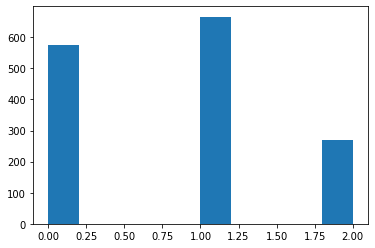

In [66]:
# We appear to have a good spread , lets inspect the outcome
plt.hist(labels)

In [67]:
len(dataset_tokenized['headers'])

1508

In [68]:
len(labels)

1508

In [69]:
# Clustering based just on the headers may not be effective as the content may not matche with the header
list(zip(dataset_tokenized['headers'], labels))[:50]

[('Job Requirements', 1),
 ('Responsibilities', 1),
 ('Qualifications', 1),
 ('Job Responsibilities', 1),
 ('Requirements', 1),
 ('Job Requirements:', 1),
 ('Key Responsibilities', 1),
 ('Job Description', 1),
 ('Key Responsibilities:', 1),
 ('Responsibilities:', 1),
 ('Requirements:', 1),
 ('Preferred Qualifications', 1),
 ('Job Description:', 1),
 ('Minimum Qualifications', 1),
 ('The above eligibility criteria are not exhaustive. A*STAR may include additional selection criteria based on its prevailing recruitment policies. These policies may be amended from time to time without notice. We regret that only shortlisted candidates will be notified.',
  2),
 ('Key Responsibilities:\xa0', 1),
 ('Job Requirements:\xa0', 1),
 ('Key Responsibilities ', 1),
 ('Job Requirements ', 1),
 ('Job Responsibilities:', 1),
 ('Overview', 0),
 ('Description', 0),
 ('Qualifications:', 1),
 ('JOB REQUIREMENTS', 1),
 ('Requirement', 0),
 ('More Information', 0),
 ('Main Duties & Responsibilities', 1),
 ('

#### Manual Mapping

- Eliminate headers with no values : I.e Sentences in bold but contain no lists or contains text but no bullet points
- Remove punctuations to get rid of `Job Requirements:` vs `Job Requirements`
- Rename, combine headers to appropriate ones 

End result: we want to have 2 core headers with Job requirements (requirements from the candidate, qualficiations, and Job Responsibilities or Description (JD, or whatever that is demanded from the candidates)

In [70]:
jd_headers_list = ['description','responsibilities','responsibility','scope','purpose',\
    'role','expect','do','accountabilities','activity','work']
jd_secondary_headers_list = ['',' ',':','\xa0']
jr_headers_list = ['requirement','skill', 'qualification','attributes','succeed','possess','experience','prefer','education',\
    'certification','mandatory','essential','looking','candidate','expertise','competenc','profile']

In [71]:
import copy

TOTAL_JOB_RAW_DATA_COPY = copy.deepcopy(TOTAL_JOB_RAW_DATA)

In [72]:
data_copy = copy.deepcopy(data)

In [73]:
TOTAL_JOB_RAW_DATA_COPY[12][3]

{'Job Description': 'Provide customized research and analysis to identify, qualify, cultivate, solicit and steward donors and prospects.Conduct financial or biographical research and compose profiles on individuals, corporations and foundations to identify, qualify, and prioritize prospective donors; independently research, select sources for research and ensures accuracy of reports.Conduct web-based research of publicly available information and monitor news and publicly-available information from professional publications, press releases and major newspapers on prospects and potential prospects to provide comprehensive reports of personal, financial and relationship based information and for solicitation strategy recommendations.Work collaboratively with and as a liaison to fundraisers and senior leaders, work to increase the pool of potential leadership gift donors and provides highly customized and strategic information that helps build increase in giving..Analyze prospective donor

In [74]:
for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
    jd = []
    jr = []
    others = []
    header_list = row[3].keys()
    for header_idx, header in enumerate(header_list):
        # print(header)
        # print(row[3][header])
        # sometimes something can happen to the first header and get attributed to nothing for example:
        if (header_idx==0) and (header in jd_secondary_headers_list):
            jd.append(row[3][header])
        elif any(sample in header.lower() for sample in jd_headers_list):
            jd.append(row[3][header])
        elif any(sample in header.lower() for sample in jr_headers_list):
            jr.append(row[3][header])
        else:
            others.append([header, row[3][header]])
    #print({'jd':jd,'jr':jr,'others':others})
    TOTAL_JOB_RAW_DATA_COPY[row_idx][3] = {'jd':jd,'jr':jr,'others':others}

        

In [75]:
len(data['job_title'])

1436

In [76]:
TOTAL_JOB_RAW_DATA[155][3]

{'Your new role': 'Lead the design and delivery of data solutions at Group level for the various business units..Interact with business users and stakeholders to identify business needs and then translate them into technical requirements.Define group wide Data strategies and solutions for deployment, working with other Data Engineers, Data Analysts and Data Architects.Implement effective data management and governance tools, to ensure quality and consistency of data.Keep updated on latest data technologies in the market to be integrated..',
 "What you'll need to succeed": 'At least 5 years of Data Analytics experience with 1 year of leadership and technical direction management.Strong knowledge working with various data tools such as ETL tools, data warehousing, and business intelligence tools..Business analysis skills to partner with users and translate technical requirements.Experience in designing data solutions and data structure classifications.'}

In [77]:
TOTAL_JOB_RAW_DATA_COPY[155][3]

{'jd': ['Lead the design and delivery of data solutions at Group level for the various business units..Interact with business users and stakeholders to identify business needs and then translate them into technical requirements.Define group wide Data strategies and solutions for deployment, working with other Data Engineers, Data Analysts and Data Architects.Implement effective data management and governance tools, to ensure quality and consistency of data.Keep updated on latest data technologies in the market to be integrated..'],
 'jr': ['At least 5 years of Data Analytics experience with 1 year of leadership and technical direction management.Strong knowledge working with various data tools such as ETL tools, data warehousing, and business intelligence tools..Business analysis skills to partner with users and translate technical requirements.Experience in designing data solutions and data structure classifications.'],
 'others': []}

In [78]:
other_section = {}
for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
    header_list = row[3]
    others = header_list['others']
    if len(others)!=0:
        other_section[row_idx] = others

In [79]:
other_section

{9: [['For Research Fellow Position',
   'A PhD degree in a relevant area, e.g., Control Engineering, Chemical Engineering, Automation, Systems Engineering, Computer Science or Applied Mathematics;.Good publication record;.Experienced in advanced process control, machine learning, and programming languages (e.g., python, Matlab, C++, etc).This position is available from July 2022 to December 2022.']],
 21: [['Research Analyst/ Associate/ Fellow in Machine Learning and Artificial Intelligence (ML/AI)',
   "Design research projects in close collaboration with the Institute's Directors (Prof. Sumit Agarwal / A.Prof Johan Sulaeman / A.Prof Zhang Weina) and Research Affiliates.Take ownership and responsibility for the successful delivery of research projects, ensuring they are completed within the required deadline and allocated budget, and meeting/exceeding project specifications and targets.Participate in pre-project activities such as identifying required resources to ensure project comp

In [80]:
# now to add them and derive the final pandas dataframe

In [81]:
TOTAL_JOB_RAW_DATA_COPY[0][3]['jd'][0]

'Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and platform engineering..'

In [82]:
jd_list = []
jr_list = []
others_list = []

for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
    free_format_section = row[3]
    if len(free_format_section['jd']) >0 :
        jd_list.append(free_format_section['jd'][0])
    else:
        jd_list.append("None")
    if len(free_format_section['jr']) >0 :
        jr_list.append(free_format_section['jr'][0])
    else:
        jr_list.append("None")
    if len(free_format_section['others']) >0 :
        others_list.append(free_format_section['others'])
    else:
        others_list.append("None")

assert (len(jd_list)==len(jr_list)==len(others_list))

In [83]:
data.update({'job_description':jd_list,'job_requirements':jr_list,'others':others_list})

In [84]:
for key in data.keys():
    print(f"Length of {key} : {len(data[key])}")

Length of job_title : 1436
Length of company_name : 1436
Length of career_level : 1436
Length of job_type : 1436
Length of job_specialisations : 1436
Length of url : 1436
Length of location : 1436
Length of low_salary : 1436
Length of high_salary : 1436
Length of post_date : 1436
Length of job_description : 1436
Length of job_requirements : 1436
Length of others : 1436


In [85]:
data_pd = pd.DataFrame.from_dict(data)

In [86]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   job_title            1436 non-null   object        
 1   company_name         1436 non-null   object        
 2   career_level         1436 non-null   object        
 3   job_type             1436 non-null   object        
 4   job_specialisations  1436 non-null   object        
 5   url                  1436 non-null   object        
 6   location             1436 non-null   object        
 7   low_salary           1436 non-null   object        
 8   high_salary          1436 non-null   object        
 9   post_date            1436 non-null   datetime64[ns]
 10  job_description      1436 non-null   object        
 11  job_requirements     1436 non-null   object        
 12  others               1436 non-null   object        
dtypes: datetime64[ns](1), object(12)


In [87]:
# We can see that the scrape and preprocessing is not perfect, there are some with incomplete information
# Furthermore we still need to clean up the Job title, job description and job requirements
data_pd.sample(15,random_state=RANDOM_STATE)

job_title  \
594                                                                   Executive, Healthcare Information (Analytics And Training)   
754                                                               Research Associate, (Computer Science/Electrical Engineering)    
630                                                                                  Research Engineer I,  (Computer Science)      
1259                                                                                         Research Scientist  (Engineering)     
903                                                                Research Assistant,  (Microbiology  Wastewater Surveillance)    
1175                                                                                                     Lead Data Scientist,      
762   SVP / VP, Delivery Lead (Digital Banking), Group Consumer Banking and Big Data Analytics Technology, Technology & Operat     
1372                                                                                      Research Scientist (Microfabrication)    
259                                                                      Research Assistant (Computer Science and Data Science)    
316                                                                               Solution Lead, Sensors & Machine Learning Lab    
705                                                                                              Chief Scientific Officer (EDDC)   
906                                                                                              Data Scientist Intern,  Growth    
274                                                                           Assistant Manager/Assistant Principal Data Analyst   
361                                                                 Research Fellow (Signal Processing and Machine Learning),  T   
743                                                                   Associate/ Data Engineer, Government Infrastructure Group    

                                              company_name      career_level  \
594                                 SingHealth Polyclinics  Junior Executive   
754                       Nanyang Technological University  Junior Executive   
630                       Nanyang Technological University  Junior Executive   
1259                      Nanyang Technological University  Junior Executive   
903                       Nanyang Technological University  Junior Executive   
1175         ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD           Manager   
762                                       DBS Bank Limited    Senior Manager   
1372                      Nanyang Technological University  Junior Executive   
259                       Nanyang Technological University       Entry Level   
316             Changi Airport Group (Singapore) Pte. Ltd.    Senior Manager   
705   Agency for Science, Technology and Research (A*STAR)  Junior Executive   
906                                                 TikTok       Entry Level   
274                                     ST Engineering Ltd           Manager   
361                       Nanyang Technological University  Junior Executive   
743    Government Technology Agency of Singapore (GovTech)  Junior Executive   

        job_type                                       job_specialisations  \
594    Full-Time    Admin/Human Resources, Clerical/Administrative Support   
754    Full-Time              Computer/Information Technology, IT-Software   
630    Full-Time              Computer/Information Technology, IT-Software   
1259   Full-Time              Computer/Information Technology, IT-Software   
903    Full-Time                            Sciences, Science & Technology   
1175   Full-Time              Computer/Information Technology, IT-Software   
762    Full-Time              Computer/Information Technology, IT-Software   
1372   Full-Time                            Sciences, Science & Technology   
259    Full-Time       

# EDA

In [88]:
# Remove duplicates by checking against the position name and the company

data_pd_no_dup = data_pd.drop_duplicates(subset=['job_title','company_name'])

In [89]:
# We have 1151 entries remaining
data_pd_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 0 to 1434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   job_title            1151 non-null   object        
 1   company_name         1151 non-null   object        
 2   career_level         1151 non-null   object        
 3   job_type             1151 non-null   object        
 4   job_specialisations  1151 non-null   object        
 5   url                  1151 non-null   object        
 6   location             1151 non-null   object        
 7   low_salary           1151 non-null   object        
 8   high_salary          1151 non-null   object        
 9   post_date            1151 non-null   datetime64[ns]
 10  job_description      1151 non-null   object        
 11  job_requirements     1151 non-null   object        
 12  others               1151 non-null   object        
dtypes: datetime64[ns](1), object(12)


In [90]:
data_pd_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 0 to 1434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   job_title            1151 non-null   object        
 1   company_name         1151 non-null   object        
 2   career_level         1151 non-null   object        
 3   job_type             1151 non-null   object        
 4   job_specialisations  1151 non-null   object        
 5   url                  1151 non-null   object        
 6   location             1151 non-null   object        
 7   low_salary           1151 non-null   object        
 8   high_salary          1151 non-null   object        
 9   post_date            1151 non-null   datetime64[ns]
 10  job_description      1151 non-null   object        
 11  job_requirements     1151 non-null   object        
 12  others               1151 non-null   object        
dtypes: datetime64[ns](1), object(12)


In [91]:
# Let's discover what are the entries with complete information 

complete_salary_condition = (data_pd_no_dup.loc[:,'low_salary']!="unspecified") & (data_pd_no_dup.loc[:,'high_salary']!="unspecified")
complete_jd_jr_condition = (data_pd_no_dup.loc[:,'job_description']!="None") & (data_pd_no_dup.loc[:,'job_requirements']!="None")

print(f"With complete salary condition : {len(data_pd_no_dup[complete_salary_condition])}")
print(f"With complete jd and jr : {len(data_pd_no_dup[complete_jd_jr_condition])}")
print(f"With complete information condition : {len(data_pd_no_dup[complete_salary_condition & complete_jd_jr_condition])}")

With complete salary condition : 129
With complete jd and jr : 767
With complete information condition : 70


Out of the initial 1436, we have 


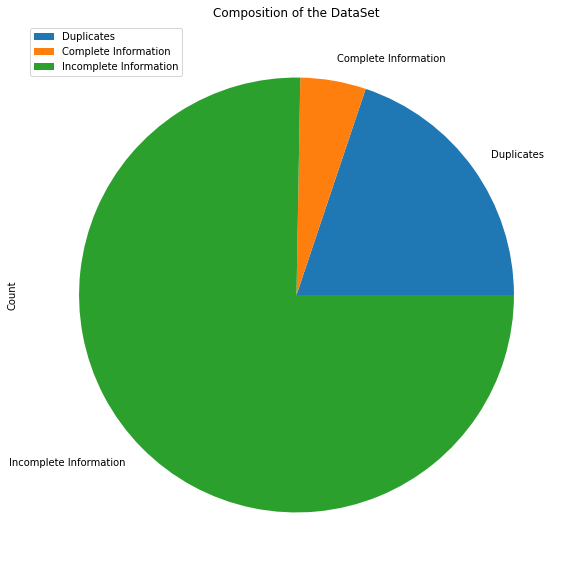

In [92]:
pd.DataFrame.from_dict({'Duplicates':1436-1151,'Complete Information':70,'Incomplete Information':1151-70}, orient='index')\
    .rename(columns={0:"Count"})\
        .plot(kind='pie', y='Count', figsize=(10,10), title="Composition of the DataSet")
plt.legend(loc='upper left')

In [93]:
complete_data_pd = data_pd_no_dup[complete_salary_condition & complete_jd_jr_condition]

In [94]:
complete_data_pd.head()

job_title  \
0                                Associate Director, Risk Analytics   
20                           Research Engineer  (Machine Learning)    
37                                            Product Data Engineer   
39  Lead Professional Officer, Software  Machine Learning, AI    JT   
52                                               Lead Data Engineer   

                        company_name      career_level   job_type  \
0              Olea Global Pte. Ltd.           Manager  Full-Time   
20  Nanyang Technological University  Junior Executive  Full-Time   
37         Adecco Personnel Pte Ltd.       Entry Level  Full-Time   
39           CTES Consulting Pte Ltd    Senior Manager  Full-Time   
52  Ethos Search Associates Pte.Ltd.           Manager  Full-Time   

                                 job_specialisations  \
0   Accounting/Finance, Corporate Finance/Investment   
20      Computer/Information Technology, IT-Software   
37                    Engineering, Other Engineering   
39      Computer/Information Technology, IT-Software   
52      Computer/Information Technology, IT-Software   

                                                                                                                                                                                                                              url  \
0                                 http://www.jobstreet.com.sg/en/job/associate-director-risk-analytics-10041886?jobId=jobstreet-sg-job-10041886&sectionRank=2&token=0~9f73d33f-5513-49f5-8a01-7b53ac91e021&fr=SRP%20Job%20Listing   
20                       http://www.jobstreet.com.sg/en/job/research-engineer-machine-learning-urgent-10135668?jobId=jobstreet-sg-job-10135668&sectionRank=26&token=0~9f73d33f-5513-49f5-8a01-7b53ac91e021&fr=SRP%20Job%20Listing   
37                                           http://www.jobstreet.com.sg/en/job/product-data-engineer-10097780?jobId=jobstreet-sg-job-10097780&sectionRank=49&token=0~0090f9a9-6954-403b-8249-4e619bc50593&fr=SRP%20Job%20Listing   
39  http://www.jobstreet.com.sg/en/job/lead-professional-officer-software-machine-learning-ai-2309-jt-10124247?jobId=jobstreet-sg-job-10124247&sectionRank=52&token=0~0090f9a9-6954-403b-8249-4e619bc50593&fr=SRP%20Job%20Listing   
52                                              http://www.jobstreet.com.sg/en/job/lead-data-engineer-10091798?jobId=jobstreet-sg-job-10091798&sectionRank=73&token=0~aba14ae6-a872-4779-8357-2bc9c84dd15e&fr=SRP%20Job%20Listing   

       location low_salary high_salary  post_date  \
0       Central      6,000      12,000 2022-11-09   
20         West      3,800       4,700 2022-11-09   
37  unspecified        250         420 2022-11-09   
39         West      8,000       9,000 2022-11-09   
52  unspecified      8,000      12,000 2022-11-09   

                                                                                                                                                                                                                                                                                                                                                                                                    job_description  \
0   Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted ...   
20                                                    Conduct research and development related to Artificial Intelligence and Machine Learning applied to Air Traffic Management (ATM).Develop algorithms and models, perform data processing & mining, and perform analytics for future ATM systems.Provide support on the implementation and verification of an AI-based Digital 

In [95]:
complete_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 1428
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   job_title            70 non-null     object        
 1   company_name         70 non-null     object        
 2   career_level         70 non-null     object        
 3   job_type             70 non-null     object        
 4   job_specialisations  70 non-null     object        
 5   url                  70 non-null     object        
 6   location             70 non-null     object        
 7   low_salary           70 non-null     object        
 8   high_salary          70 non-null     object        
 9   post_date            70 non-null     datetime64[ns]
 10  job_description      70 non-null     object        
 11  job_requirements     70 non-null     object        
 12  others               70 non-null     object        
dtypes: datetime64[ns](1), object(12)
me

In [96]:
complete_data_pd['low_salary'] = complete_data_pd['low_salary'].str.replace(",","")
complete_data_pd['low_salary'] = complete_data_pd['low_salary'].astype('int')

C:\Users\Randy\AppData\Local\Temp\ipykernel_14400\4199410567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data_pd['low_salary'] = complete_data_pd['low_salary'].str.replace(",","")
C:\Users\Randy\AppData\Local\Temp\ipykernel_14400\4199410567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data_pd['low_salary'] = complete_data_pd['low_salary'].astype('int')


In [97]:
complete_data_pd['high_salary'] = complete_data_pd['high_salary'].str.replace(",","")
complete_data_pd['high_salary'] = complete_data_pd['high_salary'].astype('int')

C:\Users\Randy\AppData\Local\Temp\ipykernel_14400\2885041157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data_pd['high_salary'] = complete_data_pd['high_salary'].str.replace(",","")
C:\Users\Randy\AppData\Local\Temp\ipykernel_14400\2885041157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data_pd['high_salary'] = complete_data_pd['high_salary'].astype('int')


## Salary

In [98]:
# which job pays the most
# Does the salary commensurate with the experience? What does the salary scale with?

In [99]:
complete_data_pd.columns

Index(['job_title', 'company_name', 'career_level', 'job_type',
       'job_specialisations', 'url', 'location', 'low_salary', 'high_salary',
       'post_date', 'job_description', 'job_requirements', 'others'],
      dtype='object')

In [100]:
# Lets see if I am able to compress salary into a single feature instead of two
complete_data_pd.low_salary.median()

4000.0

In [101]:
complete_data_pd.high_salary.median()

6250.0

In [102]:
complete_data_pd.describe().T

count         mean           std    min     25%     50%     75%  \
low_salary    70.0  5803.571429   9216.133937  250.0  3500.0  4000.0  5875.0   
high_salary   70.0  8138.857143  10109.012128  420.0  5000.0  6250.0  8375.0   

                 max  
low_salary   80000.0  
high_salary  88000.0

In [103]:
import seaborn as sns

<AxesSubplot: >

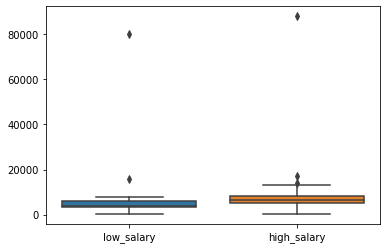

In [104]:
sns.boxplot(data=complete_data_pd)

In [105]:
# Correlation is very high which is to be expected
complete_data_pd.low_salary.corr(complete_data_pd.high_salary)

0.9881370577393935

In [106]:
# We see that the difference between both is mostly SGD1750
(complete_data_pd.high_salary - complete_data_pd.low_salary).describe()

count      70.000000
mean     2335.285714
std      1734.265681
min       170.000000
25%      1200.000000
50%      1750.000000
75%      3000.000000
max      8000.000000
dtype: float64

In [107]:
# See if salary is correlated with career_level so we can take it as a proxy

# Going by this list of values,
data_pd.career_level.unique()

array(['Manager', 'Junior Executive', 'Senior Executive',
       'Senior Manager', 'Entry Level', 'Non-Executive'], dtype=object)

C:\Users\Randy\AppData\Local\Temp\ipykernel_14400\3125515054.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  complete_data_pd.groupby(['career_level']).median().plot(kind='bar', figsize=(10,10), title= 'Does the career level tell you anything about the Salary?', grid= True)


<AxesSubplot: title={'center': 'Does the career level tell you anything about the Salary?'}, xlabel='career_level'>

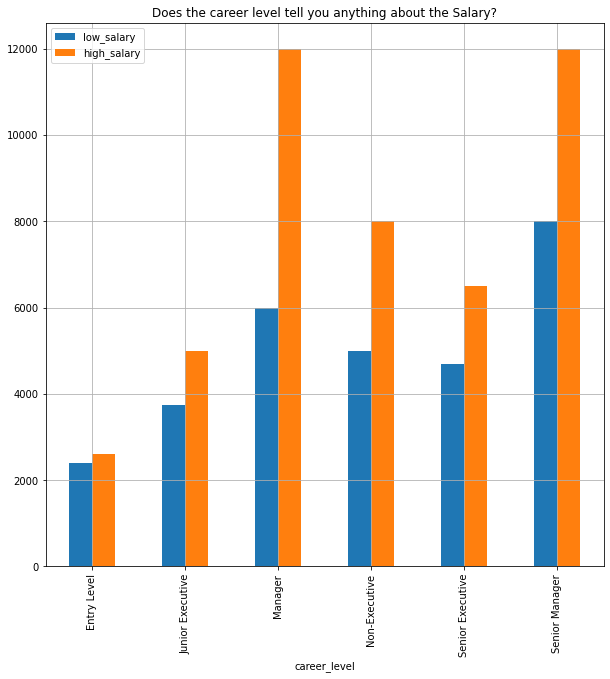

In [108]:
complete_data_pd.groupby(['career_level']).median().plot(kind='bar', figsize=(10,10), title= 'Does the career level tell you anything about the Salary?', grid= True)

I do not think there is a guideline behind the listings since job posting can contain pretty much anything, even more so for job applications on job street where salary is optional. However from what we can gleam from this set of 70 results are that the lower end of the salary appears to be more aligned with our expectations with the career level.

Everything falls neatly in place except for Non-executive and senior executive. I am expecting for non-executive to be between entry level and junior executive but the band appears to be higher than the senior executive which is odd. Then again it is possible for very large companies like tik-tok to completely skew the salaries since they have very high salaries even for starting positions which can be labelled as junior executive but the pay is comparable to a small sme's senior executive for example.

In [109]:
# The first entry is wrong since the actual listing's salary is different
complete_data_pd[complete_data_pd['career_level'] == 'Entry Level'].sample(3, random_state=RANDOM_STATE)

job_title  \
37                                       Product Data Engineer   
525    Research Scientist [Diagnostics R&D/ West/ Up to $5.5k]   
1340  URGENT Temp Executive [Data Analytics / Excel / Hybrid]    

                                company_name career_level   job_type  \
37                 Adecco Personnel Pte Ltd.  Entry Level  Full-Time   
525   Good Job Creations (Singapore) Pte Ltd  Entry Level  Full-Time   
1340                      ScienTec Personnel  Entry Level   Contract   

                                         job_specialisations  \
37                            Engineering, Other Engineering   
525                                  Sciences, Biotechnology   
1340  Admin/Human Resources, Clerical/Administrative Support   

                                                                                                                                                                                                                                    url  \
37                                                 http://www.jobstreet.com.sg/en/job/product-data-engineer-10097780?jobId=jobstreet-sg-job-10097780&sectionRank=49&token=0~0090f9a9-6954-403b-8249-4e619bc50593&fr=SRP%20Job%20Listing   
525         http://www.jobstreet.com.sg/en/job/research-scientist-%5Bdiagnostics-r-d-west-up-to-%245.5k%5D-10113246?jobId=jobstreet-sg-job-10113246&sectionRank=365&token=0~06ecf416-689a-4d9b-a57d-5f5977d048a1&fr=SRP%20Job%20Listing   
1340  http://www.jobstreet.com.sg/en/job/*urgent*-temp-executive-%5Bdata-analytics-excel-hybrid%5D-j39099-10086712?jobId=jobstreet-sg-job-10086712&sectionRank=1388&token=0~b766f431-dbc0-48bf-a64d-bbf14ff05a41&fr=SRP%20Job%20Listing   

         location  low_salary  high_salary  post_date  \
37    unspecified         250          420 2022-11-09   
525          West        3500         5500 2022-11-09   
1340         West        2400         2600 2022-11-09   

                                                                                                                                                                                                                                                                                                                                                                                                      job_description  \
37    Setup, maintain, and update work centers in SAP.Support system simulation and perform UAT.Compile and analyze yield and scrap data.Participate in yield and scrap reviews and updates.Document SOPs and guidelines for Work Center, BOM, and Routing, and to ensure accuracy.Collaborate with all stakeholders on data gathering.Analyze and provide solutions for costing concerns.Support Production Order...   
525                    The company is looking for an experienced Research Scientist to assist with product development related to the diagnosis of infectious diseases..The successful candidate should be a good team player, a fast learner, and able to conduct independent research with excellent analytical, technical, and problem-solving skills..Perform data analyses & interpretation, and report writing.   
1340                                                                                                                                                             To re-establish contact with the Building Owner (BO) or Facility Management (FM) to update the contact/ building data and follow-up with the BO/ FM to encourage and convince them to come in for recertification. (e.g. close the verification).  .   

                                                                                                                                                                                                                                                                                                                                                                                                     job_requirements  \
37                        

In [110]:
# A non-executive role with a lead as a job title
complete_data_pd[complete_data_pd['career_level'] == 'Non-Executive'].sample(3, random_state=RANDOM_STATE)

job_title  \
155                      Data Analytics Lead   
263  Data Analyst | Central Area | up to $8,   
627                   NGS Research Scientist   

                                                                  company_name  \
155                                        Hays Specialist Recruitment Pte Ltd   
263  PERSOLKELLY Singapore Pte Ltd (Formerly Kelly Services Singapore Pte Ltd)   
627                                        Hays Specialist Recruitment Pte Ltd   

      career_level   job_type  \
155  Non-Executive  Full-Time   
263  Non-Executive   Contract   
627  Non-Executive  Full-Time   

                                          job_specialisations  \
155  Computer/Information Technology, IT-Network/Sys/DB Admin   
263  Computer/Information Technology, IT-Network/Sys/DB Admin   
627                            Sciences, Science & Technology   

                                                                                                                                                                                                                 url  \
155                              http://www.jobstreet.com.sg/en/job/data-analytics-lead-10135865?jobId=jobstreet-sg-job-10135865&sectionRank=212&token=0~a17e161d-719e-4f02-b4d0-d5080901e400&fr=SRP%20Job%20Listing   
263  http://www.jobstreet.com.sg/en/job/data-analyst-%7C-central-area-%7C-up-to-%248-000-10146897?jobId=jobstreet-sg-job-10146897&sectionRank=44&token=0~64842ba8-1f22-42be-ac0c-2d27d6fe7310&fr=SRP%20Job%20Listing   
627                           http://www.jobstreet.com.sg/en/job/ngs-research-scientist-10109380?jobId=jobstreet-sg-job-10109380&sectionRank=506&token=0~8dd12a8a-4a58-472e-a3d0-02f1c8d47de6&fr=SRP%20Job%20Listing   

        location  low_salary  high_salary  post_date  \
155      Central        7000         8000 2022-11-09   
263  unspecified        5000         8000 2022-11-09   
627  unspecified        4000         6000 2022-11-09   

                                                                                                                                                                                                                                                                                                                                                                                                     job_description  \
155  Lead the design and delivery of data solutions at Group level for the various business units..Interact with business users and stakeholders to identify business needs and then translate them into technical requirements.Define group wide Data strategies and solutions for deployment, working with other Data Engineers, Data Analysts and Data Architects.Implement effective data management and gove...   
263  Extract and clean the data from various data sources to generate daily, weekly and monthly reports.Set up the automation of reports from data extracted and stored by AWS.Provide data analysis and insights to identify and recommend areas of improvement.Fulfil ad-hoc data request from client and management.Have some experience in ETL processes and mapping different sources of data with key ident...   
627                                                           Set up NGS workflows and protocols.Receiving and process biological samples for NGS applications.Implement new workflow solutions and negotiations with third-party vendors.Laboratory management - organization and supply management.Sequencing runs and handling operation of sequencing instruments.General laboratory and instrument maintenance.   

                                                                                                                                                                                                                                                                                                                                                                                                    job_requ

In [111]:
# Apparently these are the companies that pay higher than average. However it is clear this is not the case if one does a search in job sites where salary information is mandatory
high_salary_condition = (complete_data_pd['low_salary'] >= complete_data_pd['low_salary'].mean()) & (complete_data_pd['high_salary'] >= complete_data_pd['high_salary'].mean())
complete_data_pd[high_salary_condition]['company_name']

0                                                           Olea Global Pte. Ltd.
39                                                        CTES Consulting Pte Ltd
52                                               Ethos Search Associates Pte.Ltd.
56                                                      Adecco Personnel Pte Ltd.
71                                                  Stellar Link Partners Pte Ltd
136                                             Achieve Career Consultant Pte Ltd
333     PERSOLKELLY Singapore Pte Ltd (Formerly Kelly Services Singapore Pte Ltd)
454                                             Achieve Career Consultant Pte Ltd
540                                                                   NCS Pte Ltd
631                                                     Adecco Personnel Pte Ltd.
723                                       Ambition Group Singapore Pte. Ltd. (SG)
729                                             Achieve Career Consultant Pte Ltd
1139            

# Autogenerate a sample JD

Let's try to generate a sample JD, JR based on the information that we have here, we will finetune a GPT3 with the JD and JRs that we have.
- Load up a dataset instance with all of the data
- Write up the trainer instance
- Train!
- Save model
- Test model

## Preprocessing the text files

In [112]:
from transformers import TextDataset, AutoTokenizer, AutoModel, pipeline

In [116]:
new_tokeniser = AutoTokenizer.from_pretrained("bert-base-uncased")

In [113]:
TRAIN_FILE_PATH = "./train_jd.txt"
TEST_FILE_PATH = "./test_jd.txt"

In [114]:
train_text = data_pd_no_dup[data_pd_no_dup["job_description"] != 'None']['job_description'].values

In [115]:
len(train_text)

826

In [129]:
train_text[:5]

array(['Develop targeted bespoke analytics models to help the venture extract value from, and monetise, data on our platforms, where such value extraction could include the likes of better client decisioning, pricing and opportunity identification..Research, design, implement and validate cutting-edge analytics and data visualization techniques to achieve targeted outcomes, such as bringing predicted outcomes closer to experience while ensuring consistency with the model ecosystem, while identifying opportunities for solutions to be leveraged across applications to broaden their scope of use and improve risk analysis..Collaborate with partner technology teams in setting up an effective model lifecycle platform on the cloud, with possible roles to play in cloud architecture and platform engineering..',
       'Engage business users to discover how knowledge graph and/or NLP can enable operations transformation, such as to enhance operation effectiveness, raise productivity and support d

In [131]:
train_text, test_text = train_test_split(train_text, test_size=0.3, random_state=RANDOM_STATE)

In [132]:
len(train_text)

578

In [133]:
len(test_text)

248

In [116]:
def write_text_files(file_path, files):
    with open(file_path, 'w', encoding='utf8') as writer:
        for line in files:
            writer.write(line)
            writer.write("\n")

write_text_files(TRAIN_FILE_PATH, train_text)

In [ ]:
dataset = TextDataset()

## Finetuning

The finetuning of the model actually takes place in Google Colab because they have GPU there. 

Reference code: https://www.kaggle.com/code/changyeop/how-to-fine-tune-gpt-2-for-beginners

In [140]:
train_dataset = TextDataset(
    tokenizer= new_tokeniser,
    file_path=TRAIN_FILE_PATH,
    block_size=500
)

In [141]:
test_dataset = TextDataset(
    tokenizer=new_tokeniser,
    file_path=TEST_FILE_PATH,
    block_size=500
)

c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\transformers\data\datasets\language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

In [ ]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset


def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator


def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)
      
  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
  )
      
  trainer.train()
  trainer.save_model()

In [ ]:
# Parameters

CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR,'data')
TRAIN_FILE_PATH = os.path.join(DATA_DIR,"train_jd.txt")
TEST_FILE_PATH = os.path.join(DATA_DIR,"test_jd.txt")

train_file_path = "/content/drive/MyDrive/Articles.txt"
model_name = 'gpt2'
output_dir = '/content/drive/MyDrive/result'
overwrite_output_dir = True
per_device_train_batch_size = 8
num_train_epochs = 5.0
save_steps = 500

In [ ]:
# Train!
train(
    train_file_path=TRAIN_FILE_PATH,
    model_name=model_name,
    output_dir=CURR_DIR,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

## Inference

In [ ]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer


def generate_text(sequence, max_length):
    model_path = "/content/model"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [ ]:
sequence = input() 
max_len = int(input()) 
generate_text(sequence, max_len) 

Check it out at huggingface youself!
https://huggingface.co/hashketh/gpt2-data-science-job-description?text=Job+Description